In [38]:
from datasets import load_dataset
from transformers import AutoTokenizer
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

repo_id='lmqg/qg_koquad'
dataset = load_dataset(repo_id)

In [39]:
print('train에 들어있는 데이터의 갯수는', len(dataset['train']))
print('validation에 들어있는 데이터의 갯수는', len(dataset['validation']))
print('test에 들어있는 데이터의 갯수는', len(dataset['test']))

train에 들어있는 데이터의 갯수는 54556
validation에 들어있는 데이터의 갯수는 5766
test에 들어있는 데이터의 갯수는 5766


In [40]:
# all_data = dataset.to_pandas() 이건 안되네.
train_data = dataset['train'].to_pandas()

In [41]:
train_data.to_csv('./qg_koquad_train.csv')
train_data_essential = train_data[['answer','question','paragraph']]
train_data_essential.to_csv('./qg_koquad_train_essential.csv')

In [42]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    
    return percentile_

print("단어 단위 지문 길이(95 percentile) =",\
      train_data['paragraph'].apply(lambda x: len(x.split(' '))).agg([percentile(0.95)]).values[0])

train_data['len'] = train_data['paragraph'].apply(lambda x: len(x.split(' ')))
print(train_data.agg({'len':['min', 'max', 'mean']}))

단어 단위 지문 길이(95 percentile) = 193.0
              len
min     47.000000
max   2244.000000
mean   115.320001


len
(0, 224]        0.973161
(224, 448]      0.026032
(448, 673]      0.000807
(673, 897]      0.000000
(897, 1122]     0.000000
(1122, 1346]    0.000000
(1346, 1570]    0.000000
(1570, 1795]    0.000000
(1795, 2019]    0.000000
Name: proportion, dtype: float64


<Axes: xlabel='len'>

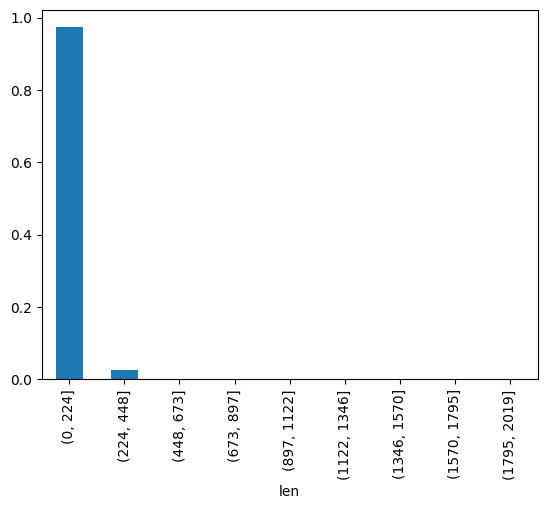

In [50]:
# bins = list(range(0, train_data['len'].max(), train_data['len'].max()/10))
import numpy as np
bins = list(np.arange(0, train_data['len'].max(), train_data['len'].max()/10).astype(int))
sentence_len_categories = pd.cut(train_data["len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

In [44]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

print("토큰 단위 문장 길이(95 percentile) =",\
      train_data['paragraph'].apply(lambda x: len(tokenizer(x)['input_ids'])).agg([percentile(0.95)]).values[0])

train_data['token_len'] = train_data['paragraph'].apply(lambda x: len(tokenizer(x)['input_ids']))
print(train_data.agg({'token_len':['min', 'max', 'mean']}))

Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors


토큰 단위 문장 길이(95 percentile) = 459.0
        token_len
min    149.000000
max   5874.000000
mean   275.216035


In [45]:
not_en_ko_num_pattern = re.compile('[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]')
known_special_chars_dict = defaultdict(int)

for sentence in train_data['paragraph']:
    special_chars = not_en_ko_num_pattern.findall(sentence)
    if len(special_chars) != 0 :
        for char in special_chars:
            if tokenizer.tokenize(char) != ['[UNK]']:
                known_special_chars_dict[char] += 1

print("klue/bert-base가 알고 있는 특수문자 개수 =", len(known_special_chars_dict))
print(known_special_chars_dict)

klue/bert-base가 알고 있는 특수문자 개수 = 440
defaultdict(<class 'int'>, {'.': 406494, '“': 8496, ',': 294334, '”': 8421, '(': 96785, ')': 96716, '《': 25442, '》': 25434, '&': 1079, '~': 5897, '‘': 8907, '’': 8908, '〈': 8794, '〉': 8800, 'の': 298, '・': 338, '/': 3338, '…': 645, '-': 14746, '情': 46, '歌': 181, ':': 7322, '州': 434, '大': 1058, '國': 716, '·': 16211, '內': 132, '山': 511, '道': 452, '海': 231, '本': 248, '福': 94, '島': 261, '宮': 206, '城': 362, '手': 75, '靑': 42, '田': 272, "'": 40108, '"': 65453, '=': 260, '[': 1120, ']': 1056, '²': 115, '生': 199, '社': 130, '<': 2749, '>': 2759, '光': 265, '金': 804, '宗': 564, '武': 365, '然': 18, '八': 86, '通': 197, '%': 6274, '水': 207, ';': 776, '?': 1275, '法': 365, '祖': 225, '別': 80, '子': 474, '小': 286, '不': 126, '野': 128, 'é': 570, '長': 282, '基': 166, '敎': 378, '!': 1518, 'ℓ': 391, '→': 374, '+': 860, '記': 140, '∼': 356, '地': 258, '方': 262, '時': 182, '#': 96, '_': 57, '商': 99, '務': 80, '合': 199, '陽': 158, '德': 268, '司': 240, '憲': 135, '府': 278, '平': 319, '文': 54

In [46]:
not_en_ko_num_pattern = re.compile('[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]')
unk_special_chars_dict = defaultdict(int)

for sentence in train_data['paragraph']:
    special_chars = not_en_ko_num_pattern.findall(sentence)
    if len(special_chars) != 0 :
        for char in special_chars:
            tokenizer.tokenize(char)
            if tokenizer.tokenize(char) == ['[UNK]']:
                unk_special_chars_dict[char] += 1

print("klue/bert-base가 모르는 특수문자 개수 =", len(unk_special_chars_dict))
print(unk_special_chars_dict)

klue/bert-base가 모르는 특수문자 개수 = 2498
defaultdict(<class 'int'>, {'ß': 38, 'Ö': 10, '飾': 26, 'り': 116, 'じ': 30, 'ゃ': 21, 'な': 73, 'い': 203, 'よ': 56, '涙': 17, 'は': 44, 'ミ': 21, 'ア': 70, 'モ': 43, 'ー': 279, 'レ': 78, '熱': 20, '姬': 32, '素': 32, '顔': 25, 'ま': 84, 'で': 56, '⁄': 62, '陸': 74, '奥': 21, '国': 152, '遠': 65, '畿': 16, '岩': 26, '森': 79, '秋': 63, '電': 88, '李': 518, '魯': 23, '鎬': 6, '達': 78, '篤': 15, '恭': 79, '殿': 145, '洪': 131, 'Š': 6, 'ų': 6, '⅓': 16, '諡': 61, '衆': 71, '遷': 7, '位': 116, '帳': 11, 'ε': 34, 'ν': 78, 'ύ': 11, 'δ': 49, 'ρ': 81, 'α': 190, '交': 53, '泰': 70, '弘': 117, 'è': 106, '永': 154, '失': 31, '楽': 44, '園': 103, '系': 51, '沙': 40, '督': 27, 'ə': 94, 'ˈ': 92, 'ɪ': 38, 'ʊ': 34, 'Κ': 24, 'λ': 88, 'ι': 100, 'σ': 72, 'τ': 93, 'ώ': 14, '–': 861, '密': 48, '旨': 39, '備': 48, '忘': 15, '半': 47, '÷': 15, 'χ': 21, '組': 63, '坊': 36, '持': 44, '尹': 127, '沔': 15, '汝': 22, '良': 129, '津': 77, '淳': 26, '千': 76, '訟': 25, '爭': 38, '喪': 11, '服': 21, '凡': 11, '⅔': 15, '改': 48, '項': 28, '拜': 13, '楠': 2